# Cellular automata for gamma ray track finding
#### Andrei R. Hanu - andrei.hanu@nasa.gov | Spencer R. Deevy - spencer.r.deevy@nasa.gov

In [48]:
# Matplotlib & other data plotting libraries
from matplotlib import pyplot as plt
from matplotlib import ticker as plticker
from matplotlib import collections as mc
from matplotlib.colors import Normalize
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

import seaborn
from brewer2mpl import brewer2mpl

# Python Iteration
import itertools

# Numpy 
import numpy as np

# OpenCV
import cv2

# Python timing module
import timeit

# Python bytes to float conversion
import struct

# Show matplotlib figures inline the notebook
%matplotlib inline

In [49]:
##########################################################################################
# rcParams (Publication Quality Graphs)

fig_width_pt = 246.0  					# Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0 		# Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt	# Width in inches
fig_height = fig_width*golden_mean 		# Height in inches
#fig_size =  [fig_width, fig_height]
fig_size =  [7.3,4.2]
params = {'backend': 'pdf',
		'axes.labelsize': 16,
		'legend.fontsize':16,
		'xtick.labelsize': 16,
		'ytick.labelsize': 16,
		'font.family': 'sans-serif',
		'font.sans-serif': 'Avant Garde',
		'font.size': 16,
		'text.usetex': True,
		'figure.figsize': fig_size}

rcParams.update(params)

# Load simulation parameters from initialization file

##### (Initialization file originally named "Ion_elec.dat")

In [50]:
with open("Data/Ion_elec.dat", "rb") as init_file:
    init_file.seek(0)
    sampling_period = struct.unpack('f', init_file.read(4))[0] # Sampling period            - (ms)         - 4 bytes
    total_time = struct.unpack('i', init_file.read(4))[0]      # Total time                 - (ms)         - 4 bytes
    total_passes = struct.unpack('i', init_file.read(4))[0]    # Total readout passes       - (#)          - 4 bytes
    dimensions = struct.unpack('3h', init_file.read(6))        # Voxel dimensions (x, y, z) - (voxel)      - 2 bytes each
    resolutions = struct.unpack('2f', init_file.read(8))       # Resolutions (x/y, z)       - (mm / voxel) - 4 bytes each
    
    # Perform simple check to ensure that at least some of the input paramters are acceptable
    if total_passes == int(round(total_time / sampling_period)):
        print("Simulation parameters: [OK]")
    else:
        print("Simulation parameters: [FAIL]")

Simulation parameters: [OK]


# Load simulation images from streaming data file
##### (Streaming data file originally named "Streaming Data.dat"

In [51]:
# Open streaming data file
with open("Data/Streaming Data.dat", "rb") as streaming_file:
    XZ_raw = [[0 for x in range(dimensions[0])] for z in range(dimensions[2])] 
    YZ_raw = [[0 for y in range(dimensions[0])] for z in range(dimensions[2])]
    
    # Loop over a single volume snapshot (Can be altered for continuous passes)
    for volume in range(0, 1):
        XZ_hits = [] # Empty XZ hit list
        YZ_hits = [] # Empty YZ hit list
        
        # Build full volume images (XZ and YZ)
        for current_pass in range(0, dimensions[2]/2):
            pass_number = struct.unpack('i', streaming_file.read(4))[0]             # Current pass number
            lx_hits = struct.unpack('i', streaming_file.read(4))[0]                 # Number of lower x hits in current pass
            lx_hit_pos = struct.unpack('i'*lx_hits, streaming_file.read(4*lx_hits)) # Lower x hit positions in current pass
            lx_hit_sig = struct.unpack('f'*lx_hits, streaming_file.read(4*lx_hits)) # Lower x hit electrons in current pass
            ly_hits = struct.unpack('i', streaming_file.read(4))[0]                 # Number of lower y hits in current pass
            ly_hit_pos = struct.unpack('i'*ly_hits, streaming_file.read(4*ly_hits)) # Lower y hit positions in current pass
            ly_hit_sig = struct.unpack('f'*ly_hits, streaming_file.read(4*ly_hits)) # Lower y hit electrons in current pass
            ux_hits = struct.unpack('i', streaming_file.read(4))[0]                 # Number of upper x hits in current pass
            ux_hit_pos = struct.unpack('i'*ux_hits, streaming_file.read(4*ux_hits)) # Upper x hit positions in current pass
            ux_hit_sig = struct.unpack('f'*ux_hits, streaming_file.read(4*ux_hits)) # Upper x hit electrons in current pass
            uy_hits = struct.unpack('i', streaming_file.read(4))[0]                 # Number of Upper y hits in current pass
            uy_hit_pos = struct.unpack('i'*uy_hits, streaming_file.read(4*uy_hits)) # Upper y hit positions in current pass
            uy_hit_sig = struct.unpack('f'*uy_hits, streaming_file.read(4*uy_hits)) # Upper y hit electrons in current pass
            
            # Populate raw XZ image data for lower x hits
            for i in range(0, lx_hits):
                XZ_raw[current_pass][lx_hit_pos[i]] = lx_hit_sig[i]
                XZ_hits.append([lx_hit_pos[i], current_pass])
                
            # Populate raw XZ image data for upper x hits
            for i in range(0, ux_hits):
                XZ_raw[dimensions[2] - current_pass - 1][ux_hit_pos[i]] = ux_hit_sig[i]
                XZ_hits.append([ux_hit_pos[i], dimensions[2] - current_pass - 1])
                
            # Populate raw YZ image data for lower y hits
            for i in range(0, ly_hits):
                YZ_raw[current_pass][ly_hit_pos[i]] = ly_hit_sig[i]
                YZ_hits.append([ly_hit_pos[i], current_pass])
                
            # Populate raw YZ image data for upper y hits
            for i in range(0, uy_hits):
                YZ_raw[dimensions[2] - current_pass - 1][uy_hit_pos[i]] = uy_hit_sig[i]
                YZ_hits.append([uy_hit_pos[i], dimensions[2] - current_pass - 1])
    
    # Convert to numpy array
    XZ_hits = np.array(XZ_hits)
    YZ_hits = np.array(YZ_hits)
    
    # Sort first by lowest Z coordinate, then by lowest position coordinate
    XZ_hits = XZ_hits[np.lexsort((XZ_hits[:, 0],XZ_hits[:, 1]))]
    YZ_hits = YZ_hits[np.lexsort((YZ_hits[:, 0],YZ_hits[:, 1]))]

# Plot volume snapshot for XZ and YZ projections

Saving plot of initial track segments for the XZ projection to: Raw_Data_CA_XZYZ.pdf


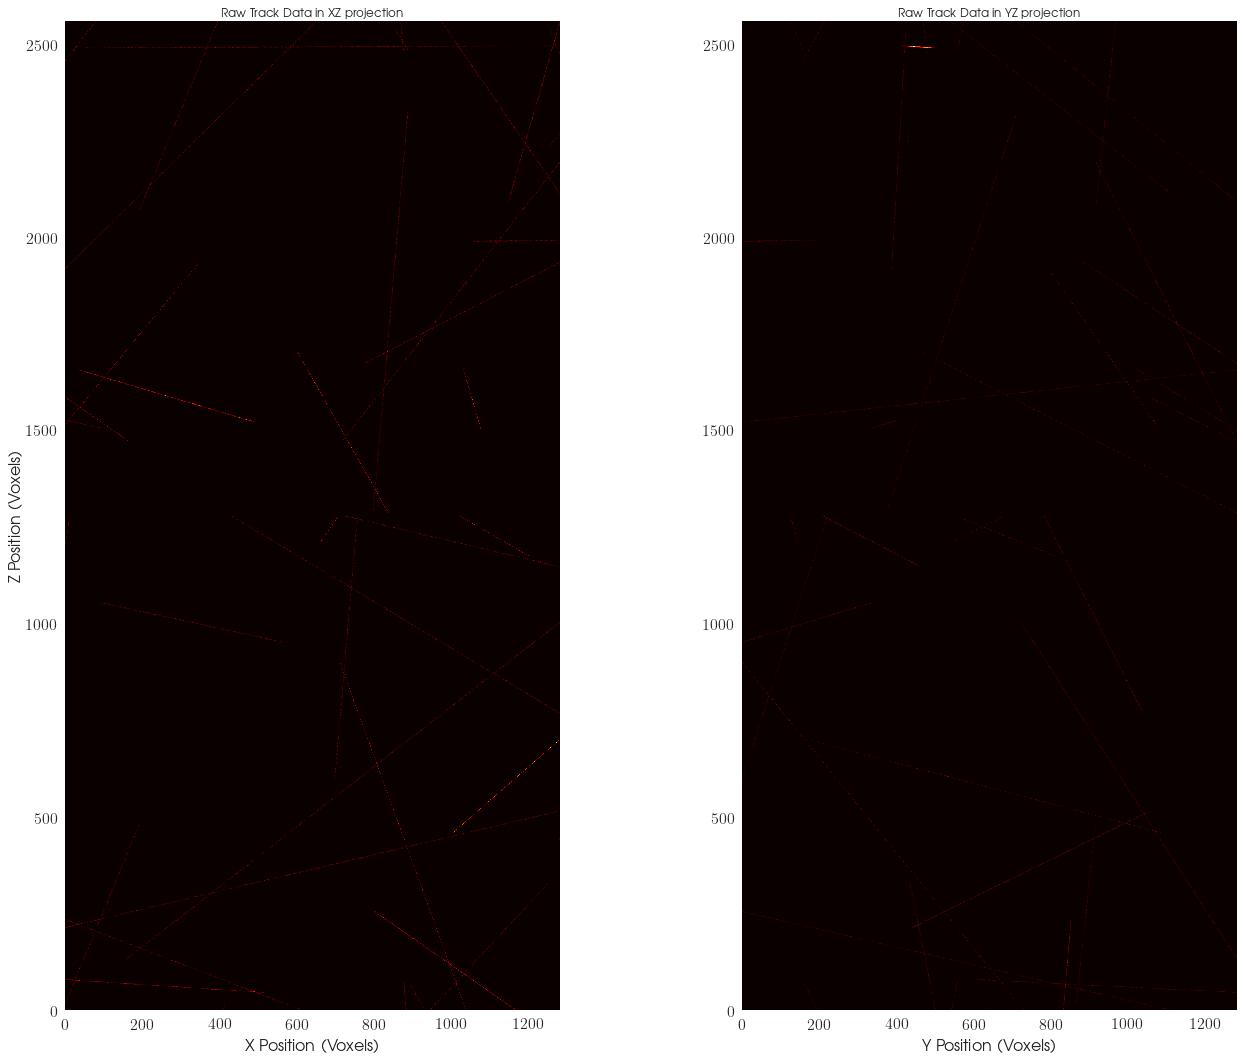

In [52]:
# Plot raw data for XZ and YZ snapshots 
raw_fig, (ax_raw_XZ, ax_raw_YZ) = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))

ax_raw_XZ.imshow(XZ_raw, origin='lower', cmap="hot") 
ax_raw_YZ.imshow(YZ_raw, origin='lower', cmap="hot")

ax_raw_XZ.grid(False)
ax_raw_YZ.grid(False)

ax_raw_XZ.set_xlabel('X Position (Voxels)')
ax_raw_YZ.set_xlabel('Y Position (Voxels)')
ax_raw_XZ.set_ylabel('Z Position (Voxels)')

ax_raw_XZ.set_title('Raw Track Data in XZ projection')
ax_raw_YZ.set_title('Raw Track Data in YZ projection')

plt.tight_layout() # Spaces titles out properly

# Save the figure 
fileRawXZYZ ='Raw_Data_CA_XZYZ.pdf'
plt.savefig(fileRawXZYZ)
print 'Saving plot of initial track segments for the XZ projection to: ' + fileRawXZYZ

plt.show(raw_fig)

# Build a KD Tree of Detector Hits

In [53]:
from scipy.spatial import KDTree, cKDTree

# Insert XZ and YZ hits into a kd-tree
treeXZ = cKDTree(XZ_hits, leafsize = 15)
treeYZ = cKDTree(YZ_hits, leafsize = 15)

# Initial Track Segment Generation

In [54]:
# Function to calculate the angle between a track segment and the Z-axis
# Return angle and magnitude
#
# Expects a numpy ndarrays [x_i z_i x_f z_f] where:
# x_i - starting x coordinate
# z_i - starting z coordinate
# x_f - final x coordinate
# z_f - final z coordinate

def calcSegmentAngleLength(segA):
    # Create vectors
    vA = [(segA[2]-segA[0]),(segA[3]-segA[1])]
    vZ = [(0),(1)]
    vX = [(1),(0)]
    
    # Calculate the dot product between the input vector and Z/X axis
    dotvAZ = np.dot(vA,vZ)
    dotvAX = np.dot(vA,vX)
    
    # Calculate the magnitude of the input vector
    magA = np.dot(vA, vA)**0.5
    
    # Return the angle in degrees
    if dotvAX >= 0:
        return np.degrees(np.arccos(dotvAZ/magA)),magA
    else:
        return -1*np.degrees(np.arccos(dotvAZ/magA)),magA

In [58]:
# Finds all of the track segments in a given projection of the detector volume
def findTrackSegments(projection_hits, projection_tree):

    # The minimum and maximum search radii
    rMin = 1
    rMax = 3
    rStep = 1

    # Acceptance angle for overlaping tracks (+/- degrees)
    thetaAcpt = 15

    # Initialize a list which stores the track segments
    # trackSeg[0:1] = X,Z pair for Hit 1
    # trackSeg[2:3] = X,Z pair for Hit 2
    trackSeg = []

    # Loop through all of the hits and find their nearest neighbours starting from the smallest radius to the largest
    # The principal axis is Z

    # Move in the forward direction
    for (proj,z) in projection_hits:
        # Start with the smallest search radius
        rSearch = rMin

        # Initialize a list of potential track segments from the current hit
        potTrackSeg = []

        # Find all of the nearest neighbours of the current 
        # Search until you find something or the search radius exceeds the maximum allowed limit
        while rSearch < rMax:
            # Find all neighbouring hits within distance r of the current hit
            hitsNear = projection_hits[projection_tree.query_ball_point([proj, z], rSearch)]

            # Filter hits in the forward direction
            hitsForward = hitsNear[hitsNear[:,1] >= z]

            # Are there any hits forward of the current search hit?
            if len(hitsForward) > 0: 
                # Loop through the potential list of forward neighbours
                for (projNN, zNN) in hitsForward:
                    # Skip the current search hit since it will also be found in the tree
                    if (projNN,zNN) != (proj, z):
                        # We need to be careful for hits on the same Z axis such that the potential track segments
                        # are connected from lowest X coordinate to the highest 
                        # This will help to filter out overlaping track segments
                        if (zNN == z) and (projNN > proj):
                            # Same Z
                            # Connect low X to high X
                            potTrackSeg.append(np.array([proj, z, projNN, zNN]))
                        elif (zNN > z):
                            potTrackSeg.append(np.array([proj, z, projNN, zNN]))

                # Did we make any potential track segments
                if len(potTrackSeg) > 0:
                    # Yes, but they need to be filtered for duplicate angles
                    # If multiple tracks have approximately the same angle, keep the shortest one
                    for i in range(len(potTrackSeg)):
                        # Assume the track segment is a good candidate until otherwise
                        goodSegment = True
                        for j in range(len(potTrackSeg)):
                            if i != j:
                                # Compare angles & lengths
                                segi,leni = calcSegmentAngleLength(potTrackSeg[i])
                                segj,lenj = calcSegmentAngleLength(potTrackSeg[j])
                                if np.absolute(segi-segj) < thetaAcpt:
                                    # These segments are too close in angle
                                    if leni > lenj:
                                        # The current search segment is not the shortest and therefore not a valid segment
                                        goodSegment = False
                                        break

                        # If this segment is still good, append to list
                        if goodSegment == True:
                            trackSeg.append(potTrackSeg[i])

                    # We've made a good track segment. Let's stop the search here!
                    rSearch = rMax 
                else:
                    # Not yet! Increase the search radius
                    rSearch += rStep
            else:
                # Not yet! Increase the search radius
                rSearch += rStep

    # Stack the list vertically into a numpy array
    trackSeg = np.vstack(trackSeg)

    # Filter for unique track segments
    trackSeg= np.vstack({tuple(row) for row in trackSeg})

    # Sort the track segments
    # First by column 1 in ascending order 
    # Then by column 0 in ascending order
    # Then by column 3 in ascending order
    # Then by column 2 in ascending order
    return trackSeg[np.lexsort((trackSeg[:, 2],trackSeg[:, 3],trackSeg[:, 0],trackSeg[:, 1]))]

In [59]:
# Find initial track segments for XZ and YZ projections
XZ_seg = findTrackSegments(XZ_hits, treeXZ)
YZ_seg = findTrackSegments(YZ_hits, treeYZ)

Saving plot of initial track segments for the XZ projection to: Track_Segments_Initial_CA_XZYZ.pdf


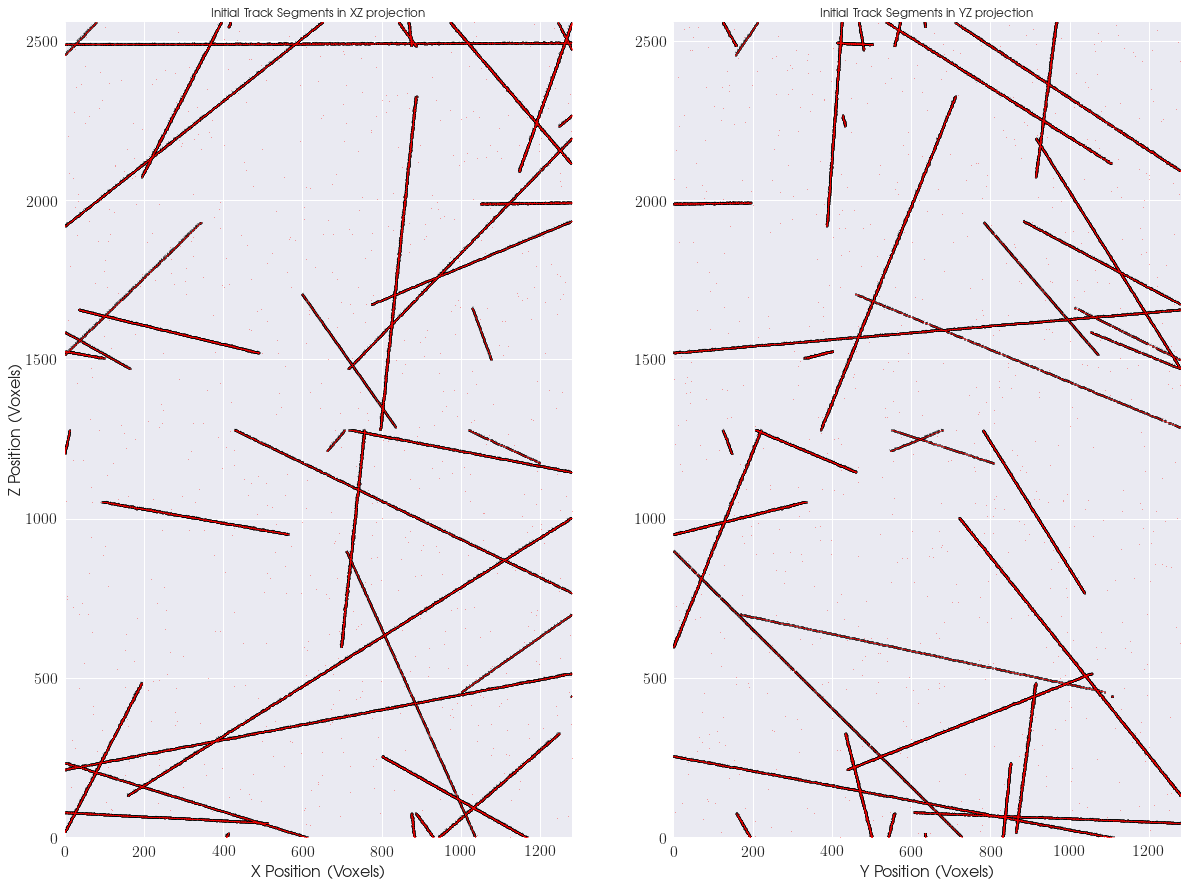

In [60]:
# Plot initial track segments for XZ and YZ projections
seg_fig, (ax_seg_XZ, ax_seg_YZ) = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))


# Use LineCollection to efficiently plot the many track segments
lcx = mc.LineCollection(zip(zip(XZ_seg[:,0],XZ_seg[:,1]),zip(XZ_seg[:,2],XZ_seg[:,3])), linewidths=3,color='k')
lcy = mc.LineCollection(zip(zip(YZ_seg[:,0],YZ_seg[:,1]),zip(YZ_seg[:,2],YZ_seg[:,3])), linewidths=3,color='k')
ax_seg_XZ.add_collection(lcx)
ax_seg_YZ.add_collection(lcy)

# Load the image data from CV2 into matplotlib
ax_seg_XZ.plot(XZ_hits[:,0], XZ_hits[:,1], '.', ms=1, color='red') 
ax_seg_YZ.plot(YZ_hits[:,0], YZ_hits[:,1], '.', ms=1, color='red') 

# Axis Properties
ax_seg_XZ.set_xlim(0,1280)
ax_seg_XZ.set_ylim(0,2560)
ax_seg_YZ.set_xlim(0,1280)
ax_seg_YZ.set_ylim(0,2560)

# Titles
ax_seg_XZ.set_xlabel('X Position (Voxels)')
ax_seg_YZ.set_xlabel('Y Position (Voxels)')
ax_seg_XZ.set_ylabel('Z Position (Voxels)')

ax_seg_XZ.set_title('Initial Track Segments in XZ projection')
ax_seg_YZ.set_title('Initial Track Segments in YZ projection')

# Save the figure 
fileTrackSegXZYZ ='Track_Segments_Initial_CA_XZYZ.pdf'
plt.savefig(fileTrackSegXZYZ)
print 'Saving plot of initial track segments for the XZ projection to: ' + fileTrackSegXZYZ

# Show the image
plt.show(seg_fig)